<a href="https://colab.research.google.com/github/ccg-esb-lab/ARCfitness/blob/main/MonodGillespieARC_5_stability_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of ARC Stability Simulations

This notebook analyzes the results of the in silico competition experiments.  
It aggregates replicate simulations, computes persistence and rescue probabilities as a function of the switching time *K*, and summarizes outcome categories (clearance, coexistence, fixation) for each ARC family.  
The notebook also generates the figures and quantitative summaries used in the main text and Supplementary Information.


In [1]:
import os
import re
import time
import copy
import pickle
from dataclasses import dataclass

from pathlib import Path, Path as P
from pathlib import Path
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch, Ellipse
from matplotlib.ticker import MultipleLocator
from numpy.linalg import lstsq

plt.rcParams.update({
    "axes.labelsize": 16,   # fontsize for axis labels
    "xtick.labelsize": 14,  # fontsize for x-axis tick labels
    "ytick.labelsize": 14   # fontsize for y-axis tick labels
})

## Set experimental parameters

Model parameters:

In [2]:
initial_resource = 1.0
simulation_time = 24.0
B0=1e6
od2cells = 1e9

ref_family=''
ref_key='pMBA'

Simulation parameters:

In [3]:

labels_of_interest = ["ereA2", "aacA7", "OXA10", "dfrA31", "qacE"]

families = ["dfr", "bla", "aa", "mix", "all"]

exportData = True
simulateData = False

Ks = range(0, 101, 5)
num_days = 100

E_color = "#B63E36"
G_color = "#EBDD99"

Ks_to_show = [20, 50, 75]

THR_FIX = 0.99
THR_CLR = 0.05

scheds = ["anaerobiosis"] + [f"switch_K{k}" for k in Ks_to_show] + ["aerobiosis"]


## Clone GitHub Repo

In [4]:

REPO=True

if REPO:
    repo_url = "https://github.com/ccg-esb-lab/ARCfitness.git"
    repo_name = "ARCfitness"

    if not Path(repo_name).exists():
        !git clone {repo_url}

    REPO_ROOT = Path(repo_name).resolve()
    print("Repo root:", REPO_ROOT)

    pathCODE = REPO_ROOT / "code/"
    pathFIGURES = REPO_ROOT / "figures/"
    pathSIM = REPO_ROOT / "sim/"

    pathFIGURES.mkdir(parents=True, exist_ok=True)
    pathSIM.mkdir(parents=True, exist_ok=True)


Cloning into 'ARCfitness'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 116 (delta 39), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 39.38 MiB | 10.34 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Repo root: /content/ARCfitness


In [5]:
if not REPO:
    REPO_ROOT = Path("./").expanduser().resolve()

    if not REPO_ROOT.exists():
        raise FileNotFoundError(f"Repo not found at {REPO_ROOT}")

    print("Repo root:", REPO_ROOT)

    pathCODE    = REPO_ROOT / "code"
    pathFIGURES = REPO_ROOT / "figures"
    pathDATA    = REPO_ROOT / "data"

    # Create output dirs if missing
    pathFIGURES.mkdir(parents=True, exist_ok=True)

    pathCODE    = str(REPO_ROOT / "code")    + "/"
    pathFIGURES = str(REPO_ROOT / "figures") + "/"
    pathDATA    = str(REPO_ROOT / "data")    + "/"

    print("pathCODE:", pathCODE)
    print("pathDATA:", pathDATA)
    print("pathFIGURES:", pathFIGURES)


___

In [6]:
import sys, importlib, importlib.util

print("pathCODE =", pathCODE)
print("as str   =", str(pathCODE))

p = str(pathCODE)
if p in sys.path:
    sys.path.remove(p)
sys.path.insert(0, p)

sys.modules.pop("MonodGillespieMI", None)
sys.modules.pop("MonodGillespieMI_IO", None)

import MonodGillespieMI as MG
import MonodGillespieMI_IO as IO

print("\nLoaded MonodGillespieMI from:", MG.__file__)
print("Loaded MonodGillespieMI_IO from:", IO.__file__)


pathCODE = /content/ARCfitness/code
as str   = /content/ARCfitness/code

Loaded MonodGillespieMI from: /content/ARCfitness/code/MonodGillespieMI.py
Loaded MonodGillespieMI_IO from: /content/ARCfitness/code/MonodGillespieMI_IO.py


In [7]:
def _norm(s):
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())

def load_exp_fitness_csv(csv_path):
    """
    Load experimental fitness from a CSV export.

    Parameters:
    - csv_path: path to a CSV with columns ARC and either mean, or replicate columns named as digits.

    Returns:
    - DataFrame with columns strain, w_exp, _key.
    """
    df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")

    rep_cols = [c for c in df.columns if str(c).strip().isdigit()]

    if "mean" in df.columns:
        df["w_exp"] = pd.to_numeric(df["mean"], errors="coerce")
    else:
        df["w_exp"] = pd.to_numeric(df[rep_cols], errors="coerce").mean(axis=1)

    df = df.rename(columns={"ARC": "strain"}).dropna(subset=["strain", "w_exp"])
    df["_key"] = df["strain"].map(_norm)

    return df[["strain", "w_exp", "_key"]]


fitness_aero = load_exp_fitness_csv(REPO_ROOT / "data" / "ARC_fitness_aerobiosis.csv")
print(fitness_aero.head())

fitness_anaero = load_exp_fitness_csv(REPO_ROOT / "data" / "ARC_fitness_anaerobiosis.csv")
print(fitness_anaero.head())


   strain     w_exp    _key
0    VIM1  0.691702    vim1
1    VIM2  0.713427    vim2
2    OXA2  0.731454    oxa2
3  OXA118  0.733002  oxa118
4   IMP31  0.733117   imp31
   strain     w_exp    _key
0   dfrA1  0.931405   dfra1
1   dfrA5  0.965603   dfra5
2   dfrA6  0.910117   dfra6
3   dfrA7  0.858955   dfra7
4  dfrA12  0.937613  dfra12


In [8]:

min_r2 = 0.9
csv_path = REPO_ROOT / "data" / "params_fits.csv"

fits_df, PARAMS = IO.load_all_fits(csv_path, min_r2=min_r2)
print(f"Loaded {len(PARAMS)} fitted strains with R² >= {min_r2}.")

ref_key = ("", "pMBA")
p0 = IO.get_params(fits_df, ref_key[0], ref_key[1])
print(f"p0={p0}")

p0_df = pd.DataFrame(
    {
        "V": [p0["Vmax"], p0["Vmax"]],
        "K": [p0["K"], p0["K"]],
        "c": [p0["c"], p0["c"]],
    },
    index=["E", "G"],
)

Loaded 114 fitted strains with R² >= 0.9.
p0={'Vmax': 0.941251905423746, 'K': 1.9987089057549032, 'c': 1.0671426993446756e-09}


In [9]:

schedules_dict = MG.build_switch_schedules(Ks, num_days=num_days, first_env="G", second_env="E")
MG.print_schedules_readable(schedules_dict)


switch_K0    : E(100)   [100 days]
switch_K5    : G(5) E(95)   [100 days]
switch_K10   : G(10) E(90)   [100 days]
switch_K15   : G(15) E(85)   [100 days]
switch_K20   : G(20) E(80)   [100 days]
switch_K25   : G(25) E(75)   [100 days]
switch_K30   : G(30) E(70)   [100 days]
switch_K35   : G(35) E(65)   [100 days]
switch_K40   : G(40) E(60)   [100 days]
switch_K45   : G(45) E(55)   [100 days]
switch_K50   : G(50) E(50)   [100 days]
switch_K55   : G(55) E(45)   [100 days]
switch_K60   : G(60) E(40)   [100 days]
switch_K65   : G(65) E(35)   [100 days]
switch_K70   : G(70) E(30)   [100 days]
switch_K75   : G(75) E(25)   [100 days]
switch_K80   : G(80) E(20)   [100 days]
switch_K85   : G(85) E(15)   [100 days]
switch_K90   : G(90) E(10)   [100 days]
switch_K95   : G(95) E(5)   [100 days]
switch_K100  : G(100)   [100 days]


___

## Individual-based analysis


In [10]:
def get_pair_idx(df_env, family, label):
    sub = df_env[
        (df_env['family'] == family) &
        (df_env['label'] == label)
    ]['pair_idx'].dropna().unique()

    if len(sub) == 0:
        raise KeyError(f"No pair_idx found for family={family}, label={label}")
    if len(sub) > 1:
        raise ValueError(f"Multiple pair_idx found for family={family}, label={label}: {sub}")

    return int(sub[0])


[all] df_env shape: (2242, 13)
[all] n_pairs in library: 1121
Exporting /content/ARCfitness/figuresw_scatter_all.pdf


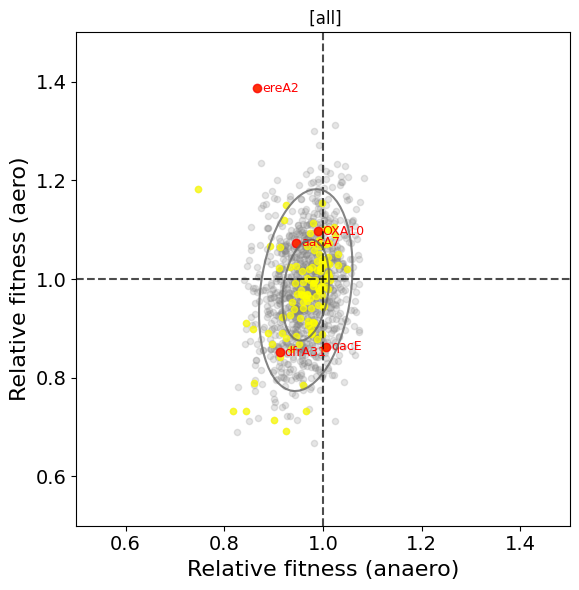

In [11]:


this_family='all'
sched_name='switch_K50'
schedule='GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

# Load fitness library for this family
fitness_csv = REPO_ROOT / "data" / f"fitness_{this_family}.csv"

df_family = (
    pd.read_csv(fitness_csv)
      .dropna(how="all")
      .dropna(axis=1, how="all")
)

if "family" in df_family.columns and this_family != "all":
    df_env = df_family[df_family["family"] == this_family].reset_index(drop=True)
else:
    df_env = df_family.reset_index(drop=True)

print(f"[{this_family}] df_env shape:", df_env.shape)

df_strains = df_env[~df_env["label"].astype(str).str.contains("_x", na=False)].reset_index(drop=True)
df_env_bivar = df_env.copy()

MG._validate_params(df_env_bivar)

all_pairs = sorted(df_env_bivar["pair_idx"].unique().tolist())
print(f"[{this_family}] n_pairs in library:", len(all_pairs))

highlight_labels = (
    df_env_bivar.loc[
             ~df_env_bivar["label"].astype(str).str.startswith("x_"),
                "label"
            ]
            .unique()
            .tolist()
)

MG.plot_w_scatter(
            df_env,
            family=this_family,
            highlight=highlight_labels,
            annotate=labels_of_interest,
            ellipse_mode='rotated',
            pathFIGURES=pathFIGURES
);

### Plot single trajectories

In [12]:
def plot_one_schedule_family(
    *,
    MG,
    df_env,
    df_family,                 # used only to build highlight/fade sets and labels
    family,
    schedule,
    sched_name,
    p0,
    initial_resource,
    labels_of_interest=(),
    this_label=None,           # if given, we simulate ONLY this label (one pair_idx)
    dilution=10.0,
    day_hours=24.0,
    Ntot0_start=1e6,
    freqA0_start=0.5,
    sim_fn=None,
    percent=True,
    to_days=True,
    alpha_bg_lines=0.2,
    pathFIGURES="",
    title_prefix="",
):
    """
    Simulate and plot ARC frequency trajectories for a single (family, schedule) setting.

    Parameters
    ----------
    MG : module-like
        Must provide `gillespie_bacterial_growth_batch`, `run_trajectories`,
        and `plot_freq_time_with_highlights`.
    df_env : pandas.DataFrame
        Fitness library table with at least: label, pair_idx, Environment, family.
        Used to select which pair_idx values are simulated.
    df_family : pandas.DataFrame or None
        Table used only to determine which pair_idx values should be highlighted
        (based on `labels_of_interest`) and to construct `label_map`.
        If None, the function falls back to using `df_env`.
    family : str
        Family identifier used to filter `df_env` and `df_family`.
    schedule : sequence of str
        Environment schedule (e.g., a list of "E"/"G" codes) passed to `MG.run_trajectories`.
    sched_name : str
        Label used in the plot title.
    p0 : dict
        Reference parameter set passed to `MG.run_trajectories`.
    initial_resource : float
        Initial resource value passed to `MG.run_trajectories`.
    labels_of_interest : sequence of str
        Labels to highlight in the plot when present in `df_family`/`df_env`.
    this_label : str or None
        If provided, only the corresponding pair_idx is simulated.
        If None, all pair_idx values for `family` are simulated.
    dilution, day_hours, Ntot0_start, freqA0_start : float
        Simulation settings forwarded to `MG.run_trajectories`.
    sim_fn : callable or None
        Simulator function. If None, defaults to `MG.gillespie_bacterial_growth_batch`.
    percent : bool
        Passed to `MG.plot_freq_time_with_highlights`.
    to_days : bool
        Passed to `MG.plot_freq_time_with_highlights`.
    alpha_bg_lines : float
        Opacity used for non-highlighted trajectories in the plot.
    pathFIGURES : str
        Output directory forwarded to `MG.plot_freq_time_with_highlights`.
    title_prefix : str
        Optional prefix appended to the plot title.

    Returns
    -------
    runs : list[dict]
        Output of `MG.run_trajectories`.
    res_list_all : list[dict]
        Reformatted run outputs for `MG.plot_freq_time_with_highlights`.
    fig, ax
        Matplotlib figure and axis returned by `MG.plot_freq_time_with_highlights`.
    """
    if sim_fn is None:
        sim_fn = MG.gillespie_bacterial_growth_batch

    d = df_env.copy()
    if "family" in d.columns:
        d = d[d["family"] == family].reset_index(drop=True)

    if d.empty:
        raise ValueError(f"No rows found for family={family}")

    if this_label is not None:
        m = d["label"].astype(str).eq(str(this_label))
        if not m.any():
            raise ValueError(f"Label '{this_label}' not found in df_env for family={family}")
        pid = int(d.loc[m, "pair_idx"].dropna().iloc[0])
        pair_indices = [pid]
    else:
        pair_indices = sorted(d["pair_idx"].dropna().astype(int).unique().tolist())

    runs = MG.run_trajectories(
        d, pair_indices, schedule, p0,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        day_hours=day_hours, dilution=dilution,
        Ntot0_start=Ntot0_start, freqA0_start=freqA0_start
    )

    if not runs:
        raise RuntimeError("MG.run_trajectories returned no runs")

    res_list_all = []
    for r in runs:
        res_list_all.append({
            "pair_idx": r["pair_idx"],
            "time": r["time"],
            "pops": r["pops"],
            "segments": r.get("segments", []),
            "day_summaries": r.get("day_summaries", None),
        })

    df_for_labels = df_family if df_family is not None else d
    if "family" in df_for_labels.columns:
        df_for_labels = df_for_labels[df_for_labels["family"] == family].copy()

    labels_of_interest = [str(x) for x in (labels_of_interest or [])]
    subset = df_for_labels[df_for_labels["label"].astype(str).isin(labels_of_interest)].copy()

    to_highlight = subset["pair_idx"].dropna().astype(int).unique().tolist()
    to_fade = [int(r["pair_idx"]) for r in runs]
    label_map = dict(zip(subset["pair_idx"].dropna().astype(int), subset["label"].astype(str)))
    highlight_colors = {}

    title_bits = [b for b in [title_prefix, family, sched_name, this_label] if b]
    title = "_".join(map(str, title_bits))

    fig, ax = MG.plot_freq_time_with_highlights(
        res_list_all,
        to_days=to_days, percent=percent,
        highlight_ids=to_highlight,
        fade_ids=to_fade,
        id_key="pair_idx",
        label_map=label_map,
        highlight_colors=highlight_colors,
        alpha_bg_lines=alpha_bg_lines,
        legend_loc="upper left",
        pathFIGURES=pathFIGURES,
        title=title,
        which="A",
    )

    return runs, res_list_all, fig, ax


Exporting /content/ARCfitness/figuresfreq_time_with_highlights_all_switch_K50_ereA2.pdf


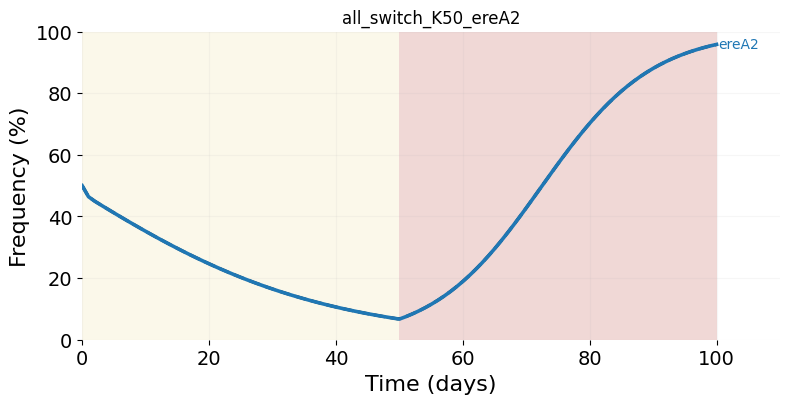

In [13]:
this_label ='ereA2'
runs, res_list_all, fig, ax = plot_one_schedule_family(
    MG=MG,
    df_env=df_env,
    df_family=df_family,
    family=this_family,
    schedule=schedule,
    sched_name=sched_name,
    p0=p0,
    initial_resource=initial_resource,
    labels_of_interest=labels_of_interest,
    this_label=this_label,
    dilution=10.0,
    pathFIGURES=pathFIGURES,
)



Exporting /content/ARCfitness/figuresfreq_time_with_highlights_all_switch_K50_ereA2.pdf


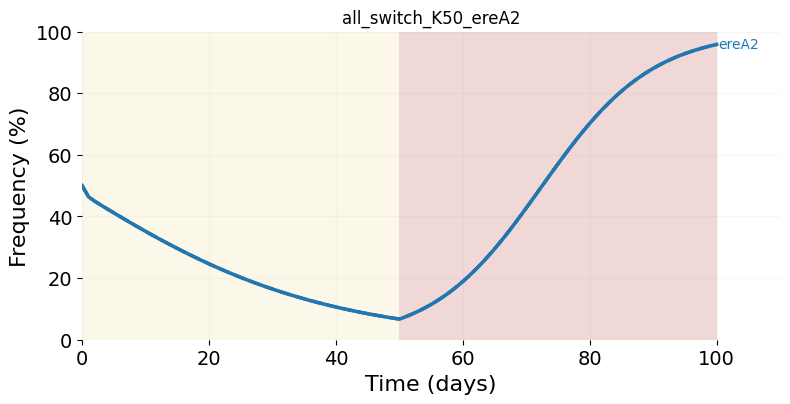

Exporting /content/ARCfitness/figuresfreq_time_with_highlights_all_switch_K50_aacA7.pdf


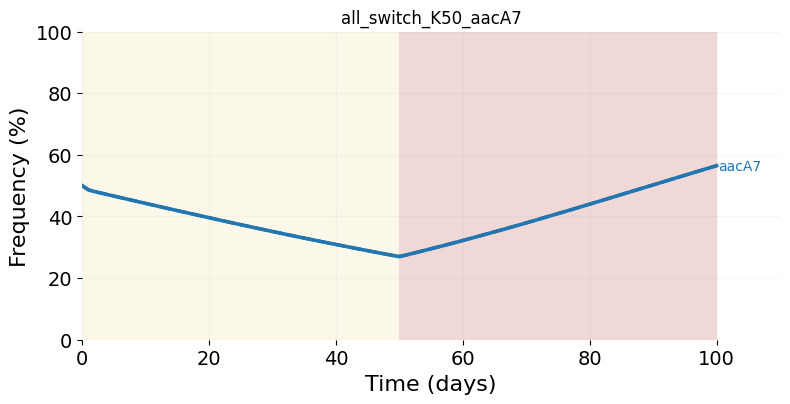

Exporting /content/ARCfitness/figuresfreq_time_with_highlights_all_switch_K50_OXA10.pdf


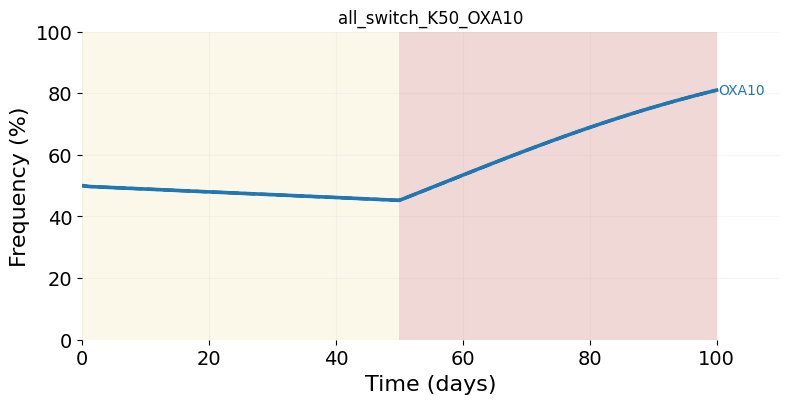

Exporting /content/ARCfitness/figuresfreq_time_with_highlights_all_switch_K50_dfrA31.pdf


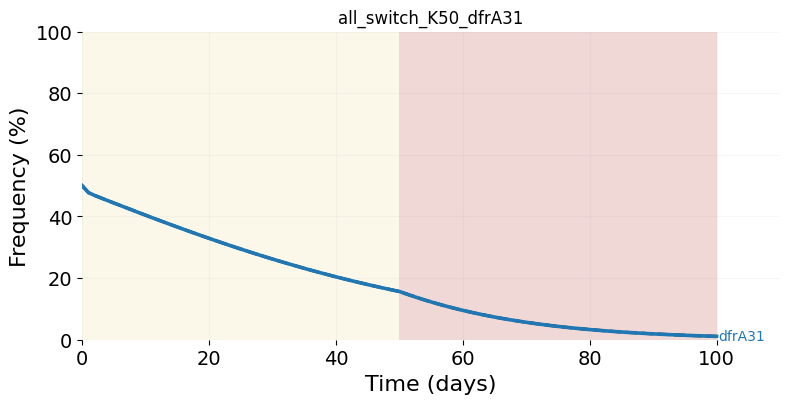

Exporting /content/ARCfitness/figuresfreq_time_with_highlights_all_switch_K50_qacE.pdf


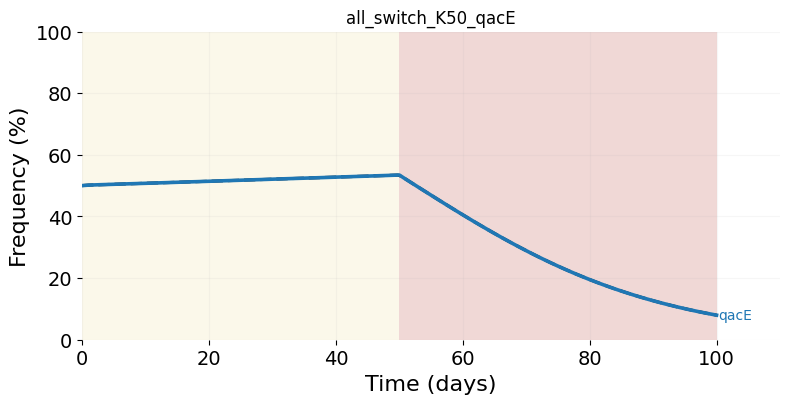

In [14]:
for this_label in labels_of_interest:

  runs, res_list_all, fig, ax = plot_one_schedule_family(
      MG=MG,
      df_env=df_env,
      df_family=df_family,
      family=this_family,
      schedule=schedule,
      sched_name=sched_name,
      p0=p0,
      initial_resource=initial_resource,
      labels_of_interest=labels_of_interest,
      this_label=this_label,
      dilution=10.0,
      pathFIGURES=pathFIGURES,
  )


## Family-based analysis

In [15]:

# ----------------------------
# Load simulation results (CSV)
# ----------------------------
pairs_csv = REPO_ROOT / "data" / "stability_pairs.csv"

df_pairs = (
    pd.read_csv(pairs_csv)
      .dropna(how="all")
      .dropna(axis=1, how="all")
)

print("Loaded:", pairs_csv)
print(df_pairs.head())

# Ensure persist_end is boolean (CSV may store as True/False strings or 0/1)
if "persist_end" in df_pairs.columns:
    if df_pairs["persist_end"].dtype == object:
        df_pairs["persist_end"] = (
            df_pairs["persist_end"].astype(str).str.strip().str.lower()
            .map({"true": True, "false": False, "1": True, "0": False})
        )
    df_pairs["persist_end"] = df_pairs["persist_end"].astype("boolean")

# ----------------------------
# Aggregated data from pairs
# ----------------------------
agg_df = IO.make_agg_from_pairs(df_pairs)
print(agg_df.head())

# ----------------------------
# Extract numeric K from schedule_name
# ----------------------------
df_pairs["K"] = (
    df_pairs["schedule_name"]
    .astype(str)
    .str.extract(r"_K(\d+)", expand=False)
    .astype(float)
)

print(df_pairs[["schedule_name", "K"]].drop_duplicates().head(10))

# ----------------------------
# Persistence summaries
# ----------------------------

# 1) Persistence vs K (all families pooled)
persist_by_K = (
    df_pairs.groupby("K", as_index=False)["persist_end"]
            .mean()
            .rename(columns={"persist_end": "P_end"})
            .sort_values("K")
)

# 2) Persistence vs K per family
persist_by_family_K = (
    df_pairs.groupby(["family", "K"], as_index=False)["persist_end"]
            .mean()
            .rename(columns={"persist_end": "P_end"})
            .sort_values(["family", "K"])
)

# 3) Mean (and SD) of persistence at the end per family × schedule_name
df_plot = (
    df_pairs.groupby(["family", "schedule_name"], as_index=False)["persist_end"]
            .agg(P_end="mean", P_end_sd="std")
)

print(df_plot.head())


Loaded: /content/ARCfitness/data/stability_pairs.csv
   pair_idx  f_end  fA_end  fB_end  persist_end  time  event  outcome  \
0         0    0.0     0.0     1.0        False    18      1  cleared   
1         1    0.0     0.0     1.0        False    19      1  cleared   
2         2    0.0     0.0     1.0        False    21      1  cleared   
3         3    0.0     0.0     1.0        False    21      1  cleared   
4         4    0.0     0.0     1.0        False    21      1  cleared   

  schedule_name                                       schedule_str  \
0     switch_K0  EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...   
1     switch_K0  EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...   
2     switch_K0  EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...   
3     switch_K0  EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...   
4     switch_K0  EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...   

                                 run_id family   label  
0  8b95552f-abd6-40bf-9126-a20

In [16]:

pairs = df_pairs.copy()
pairs['K'] = (
    pairs['schedule_name'].astype(str).str.extract(r'_K(\d+)')[0].astype(int)
)

def derive_outcome_from_ARC(f):
    if f <= THR_CLR: return 'cleared'
    if f >= THR_FIX: return 'fixated'
    return 'stable'

pairs['outcome_derived'] = pairs['f_end'].map(derive_outcome_from_ARC)
pairs['persist_end_calc'] = (pairs['outcome_derived'] != 'cleared').astype(float)

# --- Rebuild aggregates: family × schedule_name ---
agg_new = (
    pairs
    .groupby(['family','schedule_name'], as_index=False)
    .agg(
        n_pairs      = ('pair_idx','count'),
        P_end        = ('persist_end_calc','mean'),
        n_cleared    = ('outcome_derived', lambda s: (s=='cleared').sum()),
        n_stable     = ('outcome_derived', lambda s: (s=='stable').sum()),
        n_fixated    = ('outcome_derived', lambda s: (s=='fixated').sum()),
    )
)

# Fractions and identities
agg_new['frac_cleared'] = agg_new['n_cleared'] / agg_new['n_pairs']
agg_new['frac_stable']  = agg_new['n_stable']  / agg_new['n_pairs']
agg_new['frac_fixated'] = agg_new['n_fixated'] / agg_new['n_pairs']
agg_new['frac_sum']     = agg_new['frac_cleared'] + agg_new['frac_stable'] + agg_new['frac_fixated']
agg_new['P_from_fracs'] = agg_new['frac_stable'] + agg_new['frac_fixated']

# Enforce identities
assert np.allclose(agg_new['frac_sum'],       1.0, atol=1e-9), "fractions do not sum to 1"
assert np.allclose(agg_new['P_end'], agg_new['P_from_fracs'], atol=1e-9), "P_end != stable+fixated"

# --- Constant environments table (K=0 aero, K=100 anaero) ---
k_map = pairs[['schedule_name','K']].drop_duplicates()
const = (
    agg_new.merge(k_map, on='schedule_name', how='left')
           .query('K in [0, 100]')
           .sort_values(['family','K'])
           [['family','K','P_end','frac_cleared','frac_stable','frac_fixated','n_pairs']]
)
print("\n[Constant environments]")
print(const)




[Constant environments]
   family    K     P_end  frac_cleared  frac_stable  frac_fixated  n_pairs
0      aa    0  0.692748      0.307252     0.444656      0.248092     1048
2      aa  100  0.668893      0.331107     0.645992      0.022901     1048
21    all    0  0.589652      0.410348     0.402319      0.187333     1121
23    all  100  0.570919      0.429081     0.561106      0.009813     1121
42    bla    0  0.307921      0.692079     0.191089      0.116832     1010
44    bla  100  0.278218      0.721782     0.267327      0.010891     1010
63    dfr    0  0.606477      0.393523     0.527969      0.078508     1019
65    dfr  100  0.471050      0.528950     0.468106      0.002944     1019
84    mix    0  0.570450      0.429550     0.358121      0.212329     1022
86    mix  100  0.573386      0.426614     0.561644      0.011742     1022


In [17]:
def _with_K_and_simple_schedule(df, collapse_switch=True, switch_Ks=None):
    d = df.copy()
    d['K'] = (
        d['schedule_name'].astype(str)
          .str.extract(r'_K(\d+)', expand=False)
          .astype(float)
    )
    K_max = float(d['K'].max()) if d['K'].notna().any() else float('nan')

    def _simple(s, K):
        s = str(s)
        if pd.notna(K):
            if K == 0: return 'anaerobiosis'
            if K == K_max: return 'aerobiosis'
            return 'switch' if collapse_switch else f'switch_K{int(K)}'
        return s

    d['schedule_simple'] = [ _simple(s, k) for s, k in zip(d['schedule_name'], d['K']) ]

    if (switch_Ks is not None) and (collapse_switch is False):
        mask = d['schedule_simple'].isin([f'switch_K{int(k)}' for k in switch_Ks]) \
               | d['schedule_simple'].isin(['aerobiosis','anaerobiosis'])
        d = d[mask].copy()

    return d
def summarize_Pend_stats(
    df,
    metric="P_end",
    percent=True,
    families=None,
    schedules=None,
    collapse_switch=True,
    switch_Ks=None
):
    """
    Summarize mean and standard deviation of survival probability (P_end)
    per family and per environment/schedule, in a human-readable way.
    """

    import pandas as pd

    # Use the same helper as in plot_PX_heatmap to add K and schedule_simple
    d = _with_K_and_simple_schedule(df, collapse_switch=collapse_switch, switch_Ks=switch_Ks)

    # Filter families if requested
    if families is not None:
        d = d[d['family'].isin(families)]
        if d.empty:
            raise ValueError("No data after filtering by families.")

    # Work out which schedules to include
    available = sorted(d['schedule_simple'].dropna().unique().tolist())
    if schedules is None:
        schedules = available
    else:
        schedules = [s for s in schedules if s in available]
        if not schedules:
            raise ValueError(f"No data after schedule filtering. Available: {available}")

    d = d[d['schedule_simple'].isin(schedules)]

    # Group and compute stats
    summary = (
        d.groupby(['family', 'schedule_simple'])[metric]
         .agg(['mean', 'std', 'count'])
         .reset_index()
         .rename(columns={'schedule_simple': 'environment'})
    )

    if percent:
        summary['mean_Pend%'] = 100.0 * summary['mean']
        summary['std_%'] = 100.0 * summary['std']

    # Order columns nicely
    cols = ['family', 'environment', 'count']
    if percent:
        cols += ['mean_Pend%']
    else:
        cols += ['mean']

    summary = summary[cols].sort_values(['family', 'environment'])

    # Human-readable printout
    def fmt(x):
        return f"{x:0.2f}"

    print(summary.to_string(index=False, float_format=fmt))

    return summary



stats = summarize_Pend_stats(
    df_plot,
    metric="P_end",
    percent=True,
    collapse_switch=False,
    schedules=scheds
)



family  environment  count  mean_Pend%
    aa   aerobiosis      1       80.53
    aa anaerobiosis      1       76.53
    aa   switch_K20      1       79.58
    aa   switch_K50      1       83.49
    aa   switch_K75      1       83.02
   all   aerobiosis      1       74.04
   all anaerobiosis      1       66.01
   all   switch_K20      1       68.33
   all   switch_K50      1       70.47
   all   switch_K75      1       72.35
   bla   aerobiosis      1       39.80
   bla anaerobiosis      1       35.25
   bla   switch_K20      1       34.95
   bla   switch_K50      1       35.15
   bla   switch_K75      1       35.05
   dfr   aerobiosis      1       67.91
   dfr anaerobiosis      1       72.03
   dfr   switch_K20      1       72.42
   dfr   switch_K50      1       72.42
   dfr   switch_K75      1       71.34
   mix   aerobiosis      1       73.39
   mix anaerobiosis      1       63.89
   mix   switch_K20      1       65.85
   mix   switch_K50      1       70.25
   mix   switch_K75      

___

## Family-based analysis

In [19]:
def compute_rescue_probability(df_pairs, fmin_label="persist_end", verbose=True):
    """
    Compute the probability of rescue *from anaerobiosis*, and persistence probability (P_end).

    For each family and switch duration K:
      - Identify ARCs that went extinct under constant anaerobiosis (K=0)
      - Identify ARCs that survived under switch_K>0
      - Fraction rescued = rescued / total evaluated
      - Persistence (P_end) = survivors / total under K

    If verbose=True, print which labels were rescued (only real, non-synthetic labels).
    """

    df_pairs = df_pairs.copy()

    # extract K from schedule_name like "switch_K5"
    df_pairs['K'] = (
        df_pairs['schedule_name']
        .astype(str)
        .str.extract(r'_K(\d+)')[0]
        .astype(float)
    )

    # take rows under constant anaerobiosis (K=0)
    const_G = df_pairs[df_pairs['K'] == 0].copy()

    rescue_rows = []
    families = df_pairs['family'].dropna().unique()

    for fam in families:
        print("\nFamily:", fam)

        fam_df = df_pairs[df_pairs['family'] == fam]
        constG = const_G[const_G['family'] == fam][['label', fmin_label]]

        if constG.empty:
            continue

        # loop over each K value for this family
        for K, group in fam_df.groupby('K'):
            if K == 0:
                continue  # skip baseline condition

            # align K>0 group with K=0 baseline by "label"
            merged = group.merge(
                constG,
                on='label',
                suffixes=('', '_constG')
            )
            if merged.empty:
                continue

            # rescued if: present under K>0 but absent under K=0
            rescued_mask = (
                (merged[fmin_label] == 1) &
                (merged[f"{fmin_label}_constG"] == 0)
            )

            n_total = len(merged)
            n_rescued = int(rescued_mask.sum())
            frac_rescued = n_rescued / n_total if n_total > 0 else float('nan')

            # P_end = fraction of ARCs present under K>0 condition
            p_end = merged[fmin_label].mean() if n_total > 0 else float('nan')

            if verbose and n_total > 0:
                rescued_labels = (
                    merged.loc[rescued_mask, 'label']
                    .dropna()
                    .astype(str)
                    .tolist()
                )

                if len(rescued_labels) > 0:
                    print(f"[{fam}] K={int(K)} → rescued {n_rescued}/{n_total} ({100*frac_rescued:.1f}%), P_end = {100*p_end:.1f}%")

                    for lab in rescued_labels:
                        if "x_" not in lab:
                            print(f"  - {lab}")

            rescue_rows.append({
                'family': fam,
                'K': K,
                'P_rescue': frac_rescued,
                'P_end': p_end,
                'n_total': n_total,
                'n_rescued': n_rescued,
            })

    out = pd.DataFrame(rescue_rows).sort_values(['family', 'K'])
    return out
constE = f"switch_K0"
constG = f"switch_K{num_days}"   # e.g., switch_K30 if num_days = 30

rescue_by_family_K = compute_rescue_probability(df_pairs)




Family: all
[all] K=5 → rescued 9/1121 (0.8%), P_end = 66.8%
[all] K=10 → rescued 17/1121 (1.5%), P_end = 67.5%
[all] K=15 → rescued 22/1121 (2.0%), P_end = 67.8%
[all] K=20 → rescued 29/1121 (2.6%), P_end = 68.3%
[all] K=25 → rescued 33/1121 (2.9%), P_end = 68.4%
[all] K=30 → rescued 40/1121 (3.6%), P_end = 68.9%
[all] K=35 → rescued 55/1121 (4.9%), P_end = 69.8%
  - catB3
[all] K=40 → rescued 66/1121 (5.9%), P_end = 69.8%
  - VIM7
  - catB3
  - aadA13
[all] K=45 → rescued 77/1121 (6.9%), P_end = 69.8%
  - VIM7
  - catB3
  - aadA13
[all] K=50 → rescued 93/1121 (8.3%), P_end = 70.5%
  - dfrB2
  - fosN
  - VIM7
  - catB3
  - aadA13
  - aadA24
[all] K=55 → rescued 113/1121 (10.1%), P_end = 71.0%
  - qacE
  - qacM
  - dfrB2
  - qacG
  - aacC3
  - fosN
  - VIM7
  - catB3
  - aadA13
  - aadA24
[all] K=60 → rescued 126/1121 (11.2%), P_end = 71.4%
  - aacC4
  - qacE
  - qacM
  - fosF
  - dfrB2
  - qacG
  - aacC3
  - fosN
  - VIM7
  - catB3
  - aadA13
  - aadA24
[all] K=65 → rescued 143/1121 

In [20]:
constE = f"switch_K0"
constG = f"switch_K{num_days}"   # e.g., switch_K30 if num_days = 30

rescue_by_family_K = compute_rescue_probability(df_pairs)




Family: all
[all] K=5 → rescued 9/1121 (0.8%), P_end = 66.8%
[all] K=10 → rescued 17/1121 (1.5%), P_end = 67.5%
[all] K=15 → rescued 22/1121 (2.0%), P_end = 67.8%
[all] K=20 → rescued 29/1121 (2.6%), P_end = 68.3%
[all] K=25 → rescued 33/1121 (2.9%), P_end = 68.4%
[all] K=30 → rescued 40/1121 (3.6%), P_end = 68.9%
[all] K=35 → rescued 55/1121 (4.9%), P_end = 69.8%
  - catB3
[all] K=40 → rescued 66/1121 (5.9%), P_end = 69.8%
  - VIM7
  - catB3
  - aadA13
[all] K=45 → rescued 77/1121 (6.9%), P_end = 69.8%
  - VIM7
  - catB3
  - aadA13
[all] K=50 → rescued 93/1121 (8.3%), P_end = 70.5%
  - dfrB2
  - fosN
  - VIM7
  - catB3
  - aadA13
  - aadA24
[all] K=55 → rescued 113/1121 (10.1%), P_end = 71.0%
  - qacE
  - qacM
  - dfrB2
  - qacG
  - aacC3
  - fosN
  - VIM7
  - catB3
  - aadA13
  - aadA24
[all] K=60 → rescued 126/1121 (11.2%), P_end = 71.4%
  - aacC4
  - qacE
  - qacM
  - fosF
  - dfrB2
  - qacG
  - aacC3
  - fosN
  - VIM7
  - catB3
  - aadA13
  - aadA24
[all] K=65 → rescued 143/1121 

In [ ]:
def print_rescue_by_K(rescue_df):
    if rescue_df.empty:
        print("No rescue data found.")
        return

    for fam, sub in rescue_df.groupby('family'):
        print(f"\n[{fam}]")
        for _, r in sub.sort_values('K').iterrows():
            print(f"  K={int(r['K']):3d} → P_rescue={r['P_rescue']:.2f}   P_end={r['P_end']:.2f}")


print_rescue_by_K(rescue_by_family_K)


[aa]
  K=  5 → P_rescue=0.01   P_end=0.77
  K= 10 → P_rescue=0.01   P_end=0.78
  K= 15 → P_rescue=0.02   P_end=0.78
  K= 20 → P_rescue=0.03   P_end=0.80
  K= 25 → P_rescue=0.04   P_end=0.80
  K= 30 → P_rescue=0.05   P_end=0.81
  K= 35 → P_rescue=0.06   P_end=0.82
  K= 40 → P_rescue=0.08   P_end=0.83
  K= 45 → P_rescue=0.09   P_end=0.83
  K= 50 → P_rescue=0.10   P_end=0.83
  K= 55 → P_rescue=0.11   P_end=0.83
  K= 60 → P_rescue=0.13   P_end=0.84
  K= 65 → P_rescue=0.14   P_end=0.84
  K= 70 → P_rescue=0.15   P_end=0.84
  K= 75 → P_rescue=0.15   P_end=0.83
  K= 80 → P_rescue=0.16   P_end=0.83
  K= 85 → P_rescue=0.17   P_end=0.82
  K= 90 → P_rescue=0.18   P_end=0.81
  K= 95 → P_rescue=0.18   P_end=0.81
  K=100 → P_rescue=0.18   P_end=0.81

[all]
  K=  5 → P_rescue=0.01   P_end=0.67
  K= 10 → P_rescue=0.02   P_end=0.68
  K= 15 → P_rescue=0.02   P_end=0.68
  K= 20 → P_rescue=0.03   P_end=0.68
  K= 25 → P_rescue=0.03   P_end=0.68
  K= 30 → P_rescue=0.04   P_end=0.69
  K= 35 → P_rescue=0.05  

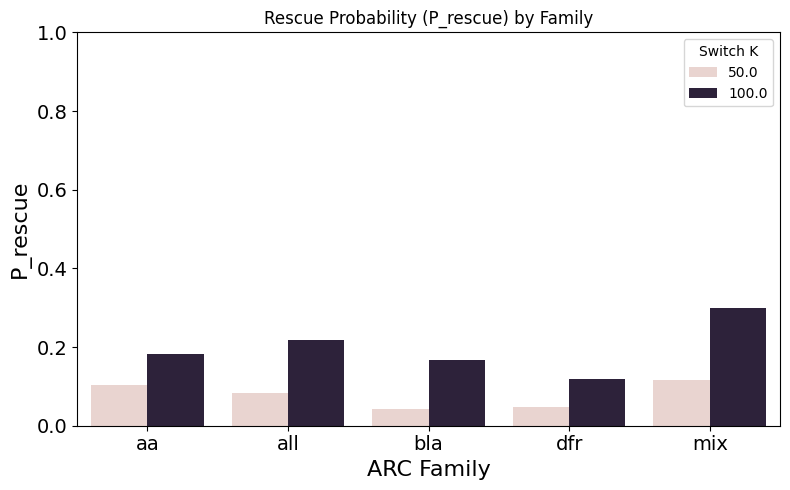

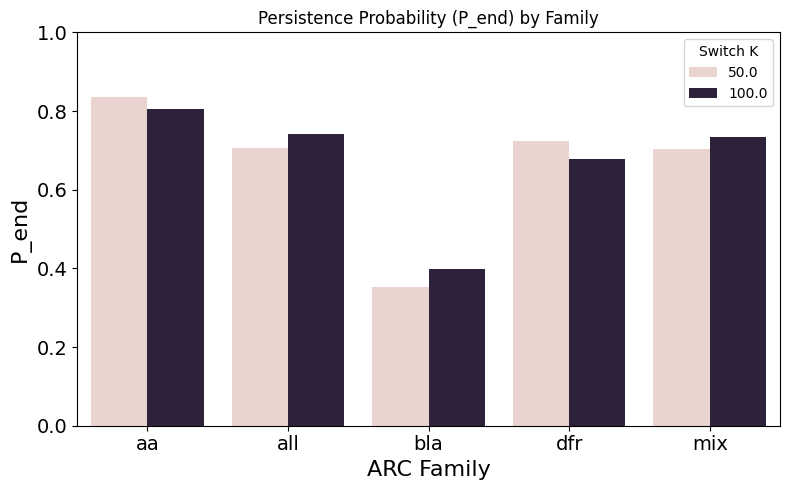

In [40]:
def plot_rescue_by_family(rescue_df, K_values=[0, 50, 100]):
    """
    Plot fraction of ARC strains rescued after anaerobic growth followed by aerobic exposure.
    """
    df_plot = rescue_df[
        (rescue_df['K'].isin(K_values)) &
        (rescue_df['family'] != 'all')
    ].copy()

    if df_plot.empty:
        print("No matching data for specified K values.")
        return

    plt.figure(figsize=(4, 4))
    sns.barplot(data=df_plot, x='family', y='P_rescue', hue='K')
    plt.ylabel('Rescued fraction (P_rescue)')
    plt.ylim(0, 1)
    plt.xlabel('ARC Family')
    plt.legend(title='Switch Day (K)')
    plt.tight_layout()
    plt.show()

def plot_persistence_by_family(rescue_df, K_values=[0, 50, 100]):
    """
    Plot fraction of ARC strains that persisted to the end of the experiment.
    """
    df_plot = rescue_df[
        (rescue_df['K'].isin(K_values)) &
        (rescue_df['family'] != 'all')
    ].copy()

    if df_plot.empty:
        print("No matching data for specified K values.")
        return

    plt.figure(figsize=(4, 4))
    sns.barplot(data=df_plot, x='family', y='P_end', hue='K')
    plt.ylabel('Final survival fraction (P_end)')
    plt.ylim(0, 1)
    plt.xlabel('ARC Family')
    plt.legend(title='Switch Day (K)')
    plt.tight_layout()
    plt.show()



plot_rescue_by_family(rescue_by_family_K)
plot_persistence_by_family(rescue_by_family_K)


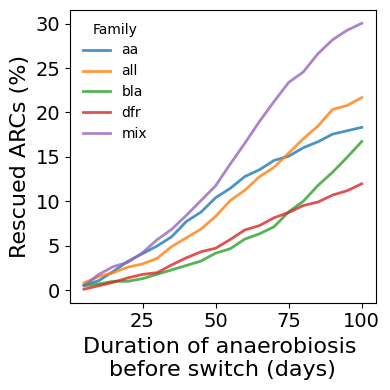

In [22]:
# Compute global rescue probability (pooling all families)
def compute_global_rescue_probability(df_pairs, fmin_label="persist_end"):
    df_pairs = df_pairs.copy()
    df_pairs['K'] = (
        df_pairs['schedule_name'].astype(str)
        .str.extract(r'_K(\d+)')[0]
        .astype(float)
    )
    constG = df_pairs[df_pairs['K'] == 0][['label', fmin_label]]

    rows = []
    for K, group in df_pairs.groupby('K'):
        if K == 0:
            continue
        merged = group.merge(constG, on='label', suffixes=('', '_constG'))
        rescued_mask = (merged[fmin_label] == 1) & (merged[f"{fmin_label}_constG"] == 0)
        frac_rescued = rescued_mask.mean()
        rows.append({'K': K, 'P_rescue_all': frac_rescued})

    return pd.DataFrame(rows).sort_values('K')

# Compute and plot
rescue_all_K = compute_global_rescue_probability(df_pairs)

fig, ax = plt.subplots(figsize=(4,4))
for fam, sub in rescue_by_family_K.groupby('family'):
    ax.plot(sub['K'], 100*sub['P_rescue'],  alpha=0.8, lw=2, label=fam)


ax.set_xlabel("Duration of anaerobiosis \nbefore switch (days)")
ax.set_ylabel("Rescued ARCs (%)")
ax.legend(title="Family", frameon=False)
ax.grid(alpha=0.)
plt.tight_layout()
plt.show()


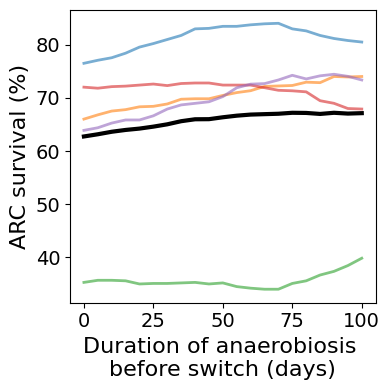

In [25]:


def plot_stability_landscape(df, families=None, pathFIGURES='', filename='stability_landscape.png'):
    """
    Plot probability of persistence (P_end) vs. switch delay (K)
    for each family as a stability landscape.
    Also includes a thick black line showing the overall (pooled) trend.
    """
    df = df.copy()
    if families is not None:
        df = df[df['family'].isin(families)]

    # clean and sort
    df = df.dropna(subset=['K', 'P_end'])
    df = df.sort_values(['family', 'K'])

    plt.figure(figsize=(4, 4))

    # --- per-family lines
    sns.lineplot(
        data=df.assign(P_end=100*df['P_end']),
        x='K', y='P_end',
        hue='family',
        linewidth=2.0,
        alpha=0.6
    )


    # --- pooled (all ARCs) trend
    overall = (
        df.groupby('K', as_index=False)['P_end']
          .mean()
          .rename(columns={'P_end': 'P_end_all'})
    )
    plt.plot(
        overall['K'], 100*overall['P_end_all'],
        color='black', lw=3, label='All ARCs'
    )

    # cosmetics
    plt.xlabel("Duration of anaerobiosis \nbefore switch (days)")
    plt.ylabel("ARC survival (%)")
    plt.grid(False)
    #plt.ylim(0, 101)
    #plt.legend(title="Family", frameon=False)
    plt.legend([], [], frameon=False)

    plt.tight_layout()

    plt.show()

plot_stability_landscape(persist_by_family_K, pathFIGURES=pathFIGURES)


In [26]:

def plot_w_scatter_highlight_ok(
    df_env,
    family=None,
    highlight=None,
    annotate=None,
    *,
    ellipse_mode='axis',      # 'axis' | 'rotated' | 'auto'
    nsig_levels=(1,2),
    ellipse_color='#666666',
    ellipse_alpha=0.8,
    ellipse_lw=1.5,
    color_highlight='red',
    color_annotate='black',
    pathFIGURES='',
    title='',
    ax=None
):
    """
    Scatter of Relative fitness (w) in G (x) vs E (y) per label, with ellipses.

    df_env must have columns: ['label','Environment','achieved_w','family'].
    """


    # --- do NOT create a new figure if ax is given ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5), sharey=False)
        own_fig = True
    else:
        own_fig = False

    # ---- sanitize inputs ----
    highlight = set(highlight or [])
    annotate  = set(annotate or [])

    d = df_env.copy()
    if family is not None:
        d = d[d['family'] == family].copy()
    if d.empty:
        raise ValueError("No rows to plot for this selection.")

    # Pivot: one row per label; columns 'E' and 'G'
    piv = (d.pivot_table(index="label", columns="Environment",
                         values="achieved_w", aggfunc="mean"))
    # Ensure we have both E and G
    missing_env = [env for env in ('E','G') if env not in piv.columns]
    if missing_env:
        raise ValueError(f"Missing environment(s) in data: {missing_env}. Need both 'E' and 'G'.")

    # Work with a clean frame (labels as index)
    piv = piv[['G','E']].dropna(how='any').copy()
    if piv.empty:
        raise ValueError("After pivot/dropna, no paired (E,G) rows remain to plot.")

    # ---- aligned masks (indexed to piv.index = labels) ----
    labels_idx = piv.index.astype(str)
    mask_x = labels_idx.str.contains(r'_x', na=False)

    # membership masks
    mask_highlight = labels_idx.isin(highlight)
    # annotate-only = in annotate but NOT in highlight
    mask_annotate  = labels_idx.isin(annotate) & ~mask_highlight


    # base scatter: two alphas depending on '_x' in label
    ax.scatter(piv.loc[ mask_x, 'G'], piv.loc[ mask_x, 'E'],
               color='grey', alpha=0.10, s=20)
    ax.scatter(piv.loc[~mask_x, 'G'], piv.loc[~mask_x, 'E'],
               color='grey', alpha=0.80, s=20)

    # highlights (face+edge in highlight color)
    if mask_highlight.any():
        face_hl = mcolors.to_rgba(color_highlight, alpha=1.0)
        edge_hl = mcolors.to_rgba(color_highlight, alpha=1.00)
        ax.scatter(piv.loc[mask_highlight, 'G'], piv.loc[mask_highlight, 'E'],
                   facecolors=face_hl, edgecolors=edge_hl, s=20, linewidths=1.5, alpha=0.1)

    # annotations (only those not highlighted)
    if mask_annotate.any():
        face_ann = mcolors.to_rgba(color_highlight, alpha=1.0)
        edge_ann = mcolors.to_rgba("black", alpha=1.00)
        #ax.scatter(piv.loc[mask_annotate, 'G'], piv.loc[mask_annotate, 'E'],
        #           facecolors=face_ann, edgecolors=edge_ann, s=20, linewidths=1.2)

        mask_nonx_highlight = (~mask_x) & mask_highlight
        mask_x_highlight = (~mask_x) & (~mask_highlight)
        mask_x_highlight_annotate = (~mask_x) & (~mask_highlight) & (mask_annotate)

        ax.scatter(
            piv.loc[mask_nonx_highlight, 'G'],
            piv.loc[mask_nonx_highlight, 'E'],
            facecolors=face_ann, edgecolors=edge_ann, alpha=0.80, s=20
        )

        for lab, row in piv.loc[mask_nonx_highlight, ['G','E']].iterrows():
            ax.text(float(row['G'])+0.01, float(row['E']), str(lab),
                    fontsize=9, ha='left', va='center', color=color_annotate, alpha=0.8)

        ax.scatter(
            piv.loc[mask_x_highlight, 'G'],
            piv.loc[mask_x_highlight, 'E'],
            color=color_annotate, alpha=0.30, s=20
        )


        for lab, row in piv.loc[mask_x_highlight_annotate, ['G','E']].iterrows():
            ax.text(float(row['G'])+0.01, float(row['E']), str(lab),
                    fontsize=9, ha='left', va='center', color=color_annotate, alpha=0.8)


    # annotations (only those annotated)
    if mask_annotate.any():
        face_ann = mcolors.to_rgba("black", alpha=0.)
        edge_ann = mcolors.to_rgba("black", alpha=0.3)
        ax.scatter(piv.loc[mask_annotate, 'G'], piv.loc[mask_annotate, 'E'],
                   facecolors=face_ann, edgecolors=edge_ann, s=20, linewidths=1.2)




    # fixed square axes + cross at (1,1)
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(0.5, 1.5)
    ax.set_aspect('equal', adjustable='box')
    ax.axhline(1, color='black', linestyle='--', alpha=0.7)
    ax.axvline(1, color='black', linestyle='--', alpha=0.7)
    ax.set_xlabel("Relative fitness (anaerobiosis)")
    ax.set_ylabel("Relative fitness (aerobiosis)")

    ax.set_title(title or family)

    # ---- ellipses ----
    x = piv['G'].to_numpy(float)
    y = piv['E'].to_numpy(float)

    def _ellipse_axis_aligned(ax_, x_, y_, nsig=(1,2), color='#666', alpha=0.8, lw=1.5):
        mx, my = np.nanmean(x_), np.nanmean(y_)
        sx, sy = np.nanstd(x_),  np.nanstd(y_)
        for k in nsig:
            w = 2*k*sx
            h = 2*k*sy
            e = plt.matplotlib.patches.Ellipse((mx,my), width=w, height=h,
                                               facecolor='none', edgecolor=color,
                                               lw=lw, alpha=alpha)
            ax_.add_patch(e)

    def _ellipse_rotated(ax_, x_, y_, nsig=(1,2), color='#666', alpha=0.8, lw=1.5):
        X = np.column_stack([x_, y_])
        X = X[np.isfinite(X).all(axis=1)]
        if X.shape[0] < 3:
            _ellipse_axis_aligned(ax_, x_, y_, nsig, color, alpha, lw); return
        C = np.cov(X.T)
        vals, vecs = np.linalg.eigh(C)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:,order]
        ang = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
        mx, my = np.nanmean(x_), np.nanmean(y_)
        for k in nsig:
            w = 2*k*np.sqrt(vals[0])
            h = 2*k*np.sqrt(vals[1])
            e = plt.matplotlib.patches.Ellipse((mx,my), width=w, height=h,
                                               angle=ang, facecolor='none',
                                               edgecolor=color, lw=lw, alpha=alpha)
            ax_.add_patch(e)

    mode = str(ellipse_mode).lower()
    if mode == 'rotated':
        _ellipse_rotated(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
    else:
        _ellipse_axis_aligned(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)

    if own_fig:
        plt.tight_layout()
        if pathFIGURES:
            filename = f"{pathFIGURES.rstrip('/')}/w_scatter_highlight_{family}.png"
            plt.savefig(filename, dpi=300)
            print(f"Exported: {filename}")
        plt.show()


    return ax

In [27]:
import re
import numpy as np
import pandas as pd

def extract_K_numeric(schedule_name: str):
    m = re.search(r'K(\d+)', str(schedule_name))
    return int(m.group(1)) if m else None

df_pairs = df_pairs.copy()
if 'K_numeric' not in df_pairs.columns:
    df_pairs['K_numeric'] = df_pairs['schedule_name'].apply(extract_K_numeric)


In [28]:
def build_alpha_by_label_from_df_pairs(
    df_pairs,
    *,
    family,
    K,
    which='A',                 # 'A' uses fA_end, 'B' uses fB_end, 'end' uses f_end
    only_highlight=None,       # optional set/list of labels to compute for
    agg='mean',                # 'mean' across replicates
    alpha_min=0.05,
    alpha_max=0.80,
):
    sub = df_pairs[(df_pairs['family'] == family) & (df_pairs['K_numeric'] == K)].copy()
    if sub.empty:
        return {}

    if only_highlight is not None:
        only_highlight = set(map(str, only_highlight))
        sub = sub[sub['label'].astype(str).isin(only_highlight)]

    col = {'A': 'fA_end', 'B': 'fB_end', 'end': 'f_end'}.get(which.upper(), which)
    if col not in sub.columns:
        raise ValueError(f"Column '{col}' not found in df_pairs")

    sub['label'] = sub['label'].astype(str).str.strip()
    sub[col] = pd.to_numeric(sub[col], errors='coerce')

    # aggregate per label across replicates
    if agg == 'mean':
        f = sub.groupby('label')[col].mean()
    elif agg == 'median':
        f = sub.groupby('label')[col].median()
    else:
        raise ValueError("agg must be 'mean' or 'median'")

    f = f.dropna()
    if f.empty:
        return {}

    # normalize to [alpha_min, alpha_max]
    fmin, fmax = float(f.min()), float(f.max())
    if np.isclose(fmin, fmax):
        # all same -> constant alpha
        return {lab: float(alpha_min) for lab in f.index}

    scaled = (f - fmin) / (fmax - fmin)
    alpha = alpha_min + (alpha_max - alpha_min) * scaled

    return {lab: float(a) for lab, a in alpha.items()}


In [29]:


def plot_w_scatter_highlight(
    df_env,
    family=None,
    highlight=None,
    annotate=None,
    *,
    alpha_by_label=None,     # <-- NEW: dict {label: alpha}
    ellipse_mode='axis',
    nsig_levels=(1,2),
    ellipse_color='#666666',
    ellipse_alpha=0.8,
    ellipse_lw=1.5,
    color_highlight='red',
    color_annotate='black',
    pathFIGURES='',
    title='',
    ax=None
):
    """
    Scatter of Relative fitness (w) in G (x) vs E (y) per label, with ellipses.

    df_env must have columns: ['label','Environment','achieved_w','family'].

    If final_freq is provided, highlighted points are drawn with alpha proportional
    to final frequency.
    """

    alpha_by_label = alpha_by_label or {}

    # --- do NOT create a new figure if ax is given ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5), sharey=False)
        own_fig = True
    else:
        own_fig = False

    # ---- sanitize inputs ----
    highlight = set(highlight or [])
    annotate  = set(annotate or [])

    d = df_env.copy()
    if family is not None:
        d = d[d['family'] == family].copy()
    if d.empty:
        raise ValueError("No rows to plot for this selection.")

    # Pivot: one row per label; columns 'E' and 'G'
    piv = (d.pivot_table(index="label", columns="Environment",
                         values="achieved_w", aggfunc="mean"))

    missing_env = [env for env in ('E','G') if env not in piv.columns]
    if missing_env:
        raise ValueError(f"Missing environment(s) in data: {missing_env}. Need both 'E' and 'G'.")

    piv = piv[['G','E']].dropna(how='any').copy()
    if piv.empty:
        raise ValueError("After pivot/dropna, no paired (E,G) rows remain to plot.")

    labels_idx = piv.index.astype(str)
    mask_x = labels_idx.str.contains(r'x_', na=False)

    mask_x = labels_idx.str.contains(r'x_', na=False)
    mask_highlight = labels_idx.isin(highlight)
    mask_x_bg = mask_x & ~mask_highlight



    mask_highlight = labels_idx.isin(highlight)
    mask_annotate  = labels_idx.isin(annotate) & ~mask_highlight


    # -----------------------------
    # base scatter (grey background)
    # -----------------------------
    ax.scatter(
        piv.loc[mask_x_bg, 'G'],
        piv.loc[mask_x_bg, 'E'],
        color='grey',
        alpha=0.05,
        s=20
    )

    ax.scatter(
        piv.loc[mask_x_bg, 'G'],
        piv.loc[mask_x_bg, 'E'],
        facecolors='none',
        edgecolors='grey',
        alpha=0.3,
        s=20,
        linewidths=0.8
    )



    # -----------------------------
    # highlights with alpha scaling
    # -----------------------------
    if mask_highlight.any():
        xs = piv.loc[mask_highlight, 'G'].to_numpy(float)
        ys = piv.loc[mask_highlight, 'E'].to_numpy(float)
        labs = piv.loc[mask_highlight].index.astype(str)

        alphas = np.array([alpha_by_label.get(lab, 0.25) for lab in labs], float)

        rgba = np.tile(mcolors.to_rgba(color_highlight, 1.0), (len(labs), 1))
        rgba[:, 3] = np.clip(alphas, 0.0, 1.0)

        ax.scatter(xs, ys, facecolors=rgba, edgecolors=rgba, s=24, linewidths=0.8)

    # -----------------------------
    # annotations (keep as you had)
    # -----------------------------
    if mask_annotate.any():
        face_ann = mcolors.to_rgba(color_highlight, alpha=1.0)
        edge_ann = mcolors.to_rgba("black", alpha=1.00)

        mask_nonx_highlight = (~mask_x) & mask_highlight
        mask_x_highlight =  (~mask_highlight)
        mask_x_highlight_annotate = (~mask_highlight) & (mask_annotate)

        ax.scatter(
            piv.loc[mask_nonx_highlight, 'G'],
            piv.loc[mask_nonx_highlight, 'E'],
            facecolors=face_ann, edgecolors=edge_ann, alpha=0.20, s=20
        )

        for lab, row in piv.loc[mask_nonx_highlight, ['G','E']].iterrows():
            ax.text(float(row['G'])+0.01, float(row['E']), str(lab),
                    fontsize=9, ha='left', va='center', color=color_annotate, alpha=0.8)

        ax.scatter(
            piv.loc[mask_x_highlight, 'G'],
            piv.loc[mask_x_highlight, 'E'],
            color=color_annotate, alpha=0.30, s=20
        )

        for lab, row in piv.loc[mask_x_highlight_annotate, ['G','E']].iterrows():
            ax.text(float(row['G'])+0.01, float(row['E']), str(lab),
                    fontsize=9, ha='left', va='center', color=color_annotate, alpha=0.8)

    #if mask_annotate.any():
    #    face_ann = mcolors.to_rgba("black", alpha=0.)
    #    edge_ann = mcolors.to_rgba("black", alpha=0.3)
    #               facecolors=face_ann, edgecolors=edge_ann, s=20, linewidths=1.2)
    #    ax.scatter(piv.loc[mask_annotate, 'G'], piv.loc[mask_annotate, 'E'],



    ax.scatter(
        piv.loc[mask_highlight, 'G'],
        piv.loc[mask_highlight, 'E'],
        facecolors='none',
        edgecolors='magenta',
        alpha=0.05,
        s=20,
        linewidths=0.8
    )




    #ax.scatter(piv.loc[~mask_x, 'G'], piv.loc[~mask_x, 'E'],
    #    facecolors='none',
    #    edgecolors='yellow', alpha=0.5, s=20)


    # fixed square axes + cross at (1,1)
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(0.5, 1.5)
    ax.set_aspect('equal', adjustable='box')
    ax.axhline(1, color='black', linestyle='--', alpha=0.7)
    ax.axvline(1, color='black', linestyle='--', alpha=0.7)
    ax.set_xlabel("Relative fitness (anaerobiosis)")
    ax.set_ylabel("Relative fitness (aerobiosis)")
    ax.set_title(title or family)

    # ---- ellipses ----
    x = piv['G'].to_numpy(float)
    y = piv['E'].to_numpy(float)

    def _ellipse_axis_aligned(ax_, x_, y_, nsig=(1,2), color='#666', alpha=0.8, lw=1.5):
        mx, my = np.nanmean(x_), np.nanmean(y_)
        sx, sy = np.nanstd(x_),  np.nanstd(y_)
        for k in nsig:
            w = 2*k*sx
            h = 2*k*sy
            e = plt.matplotlib.patches.Ellipse((mx,my), width=w, height=h,
                                               facecolor='none', edgecolor=color,
                                               lw=lw, alpha=alpha)
            ax_.add_patch(e)

    def _ellipse_rotated(ax_, x_, y_, nsig=(1,2), color='#666', alpha=0.8, lw=1.5):
        X = np.column_stack([x_, y_])
        X = X[np.isfinite(X).all(axis=1)]
        if X.shape[0] < 3:
            _ellipse_axis_aligned(ax_, x_, y_, nsig, color, alpha, lw); return
        C = np.cov(X.T)
        vals, vecs = np.linalg.eigh(C)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:,order]
        ang = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
        mx, my = np.nanmean(x_), np.nanmean(y_)
        for k in nsig:
            w = 2*k*np.sqrt(vals[0])
            h = 2*k*np.sqrt(vals[1])
            e = plt.matplotlib.patches.Ellipse((mx,my), width=w, height=h,
                                               angle=ang, facecolor='none',
                                               edgecolor=color, lw=lw, alpha=alpha)
            ax_.add_patch(e)

    mode = str(ellipse_mode).lower()
    if mode == 'rotated':
        _ellipse_rotated(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
    else:
        _ellipse_axis_aligned(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)

    if own_fig:
        plt.tight_layout()
        if pathFIGURES:
            filename = f"{pathFIGURES.rstrip('/')}/w_scatter_highlight_{family}.png"
            plt.savefig(filename, dpi=300)
            print(f"Exported: {filename}")
        plt.show()

    return ax



Family: all
  K=0: 740 surviving
  K=25: 767 surviving
  K=50: 790 surviving
  K=75: 811 surviving
  K=100: 830 surviving
Exported: /content/ARCfitness/figures/surviving_scatter_panels_all.pdf


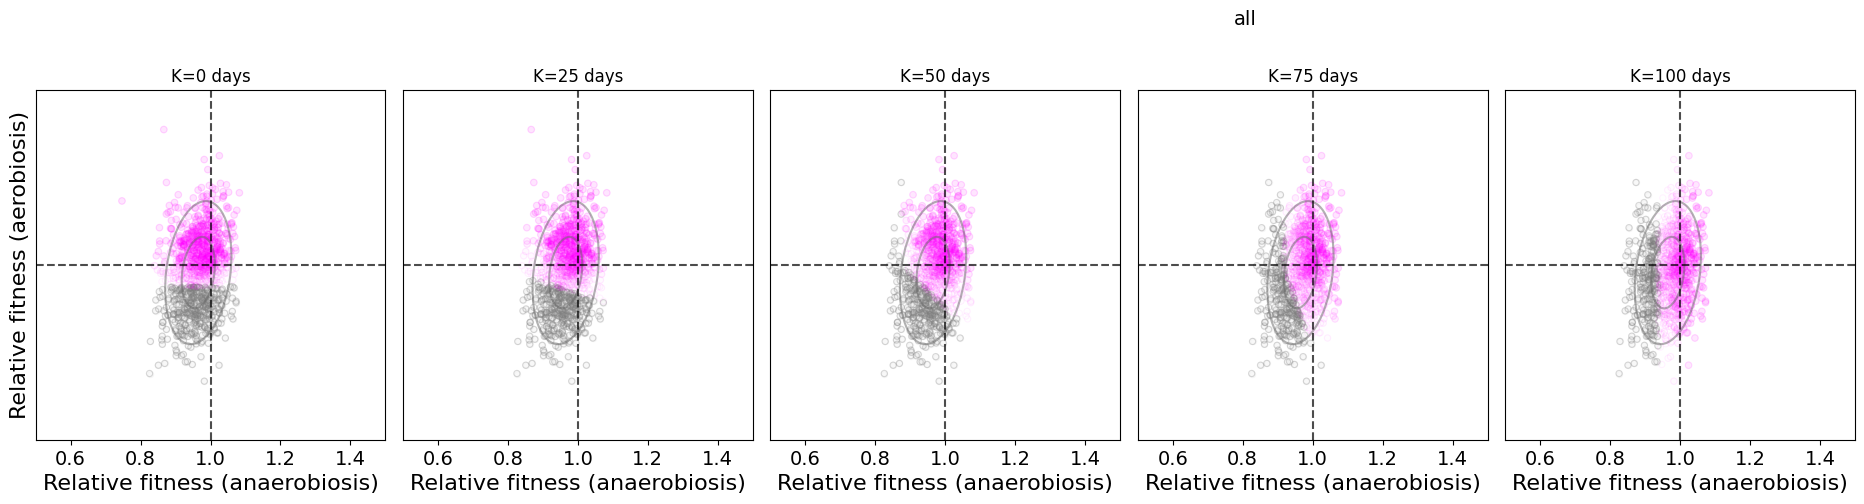

In [37]:
K_to_plot = [0,25, 50, 75, 100]

for family in ['all']:
    print(f"\nFamily: {family}")

    # Load fitness library for this family
    fitness_csv = REPO_ROOT / "data" / f"fitness_{family}.csv"

    df_family = (
        pd.read_csv(fitness_csv)
          .dropna(how="all")
          .dropna(axis=1, how="all")
    )

    if "family" in df_family.columns and family != "all":
        df_env = df_family[df_family["family"] == family].reset_index(drop=True)
    else:
        df_env = df_family.reset_index(drop=True)


    nK = len(K_to_plot)
    fig, axes = plt.subplots(1, nK, figsize=(5*nK, 5), sharey=True)
    if nK == 1: axes = [axes]

    for ax, K in zip(axes, K_to_plot):
        sub = df_pairs[(df_pairs['family'] == family) & (df_pairs['K_numeric'] == K)][['label','persist_end']].dropna()
        if sub.empty:
            ax.set_title(f"K={K} (sin datos)")
            ax.axis('off')
            continue

        surviving = sub.loc[sub['persist_end'] == 1, 'label'].astype(str).unique().tolist()
        print(f"  K={K}: {len(surviving)} surviving")

        alpha_map = build_alpha_by_label_from_df_pairs(
            df_pairs,
            family=family,
            K=K,
            which='A',                 # frequency of ARC if ARC is 'A' in your sims
            only_highlight=surviving,  # only compute alphas for highlighted labels
            agg='mean',
            alpha_min=0.0,
            alpha_max=0.1
        )

        plot_w_scatter_highlight(
            df_env,
            family=family,
            highlight=surviving,
            annotate=[],
            alpha_by_label=alpha_map,
            ellipse_mode='rotated',
            ellipse_color='#666666',
            ellipse_alpha=0.5,
            ellipse_lw=1.5,
            color_highlight='magenta',
            ax=ax,
            title=f"K={K} days"
        )
    for ax in axes[1:]:
        ax.set_yticks([])
        ax.set_ylabel("")


    if pathFIGURES:
        out = f"{pathFIGURES}/surviving_scatter_panels_{family}.pdf"
        fig.savefig(out)
        print(f"Exported: {out}")

    fig.suptitle(f"{family}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 0.15*nK, 0.95])

    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [31]:

def add_linear_gate_overlay_clipped_to_ellipse(
    ax,
    piv,
    mask_highlight,
    mx, my,
    a, b,
    ang_rad,
    *,
    extent=(0.5, 1.5, 0.5, 1.5),
    gridsize=300,
    ridge=1e-3,
    color="magenta",
    fill_alpha=0.35,
    line_alpha=0.8,
    line_lw=1.5,
    draw_line=True
):


    # --------------------------------------------------
    # Fit separating line (logistic gate)
    # --------------------------------------------------
    X = piv[['G','E']].to_numpy(float)
    y = mask_highlight.astype(int)

    Xc = X - X.mean(axis=0)
    w = np.linalg.lstsq(
        Xc.T @ Xc + ridge*np.eye(2),
        Xc.T @ (y - y.mean()),
        rcond=None
    )[0]

    # --------------------------------------------------
    # Grid
    # --------------------------------------------------
    xmin, xmax, ymin, ymax = extent
    xx = np.linspace(xmin, xmax, gridsize)
    yy = np.linspace(ymin, ymax, gridsize)
    XX, YY = np.meshgrid(xx, yy)

    Z = (w[0]*(XX - mx) + w[1]*(YY - my)) > 0

    # --------------------------------------------------
    # Colormap (transparent → color)
    # --------------------------------------------------
    rgba = mcolors.to_rgba(color, 1.0)
    cmap = ListedColormap([(0, 0, 0, 0), rgba])

    img = ax.imshow(
        Z.astype(int),
        extent=(xmin, xmax, ymin, ymax),
        origin="lower",
        interpolation="nearest",
        cmap=cmap,
        vmin=0, vmax=1,
        alpha=fill_alpha,
        zorder=3
    )

    # --------------------------------------------------
    # Ellipse (used for clipping)
    # --------------------------------------------------
    ell = Ellipse(
        (mx, my),
        width=2*a,
        height=2*b,
        angle=np.degrees(ang_rad),
        facecolor="none",
        edgecolor="none"
    )
    ax.add_patch(ell)
    img.set_clip_path(ell)

    # --------------------------------------------------
    # Optional separating line
    # --------------------------------------------------
    if draw_line:
        xs = np.linspace(xmin, xmax, 200)
        ys = my - (w[0]/w[1])*(xs - mx)
        ax.plot(xs, ys, color=color, lw=line_lw, alpha=line_alpha, zorder=4)

    return ell


from matplotlib.patches import Ellipse
import numpy as np

def draw_background_ellipse(
    ax,
    mx, my,
    a, b,
    ang_rad,
    *,
    edgecolor="#666666",
    lw=1.5,
    alpha=0.9,
    zorder=2
):
    """
    Draw a rotated ellipse (no fill) as background.
    a, b are semi-axes.
    ang_rad is rotation angle in radians.
    """
    ell = Ellipse(
        (mx, my),
        width=2*a,
        height=2*b,
        angle=np.degrees(ang_rad),
        facecolor="none",
        edgecolor=edgecolor,
        lw=lw,
        alpha=alpha,
        zorder=zorder
    )
    ax.add_patch(ell)
    return ell



Family: dfr
  K=0: 734 surviving ARCs
  K=25: 740 surviving ARCs
  K=50: 738 surviving ARCs
  K=75: 727 surviving ARCs
  K=100: 692 surviving ARCs
Exported: /content/ARCfitness/figures/surviving_ellipse_panels_dfr.pdf


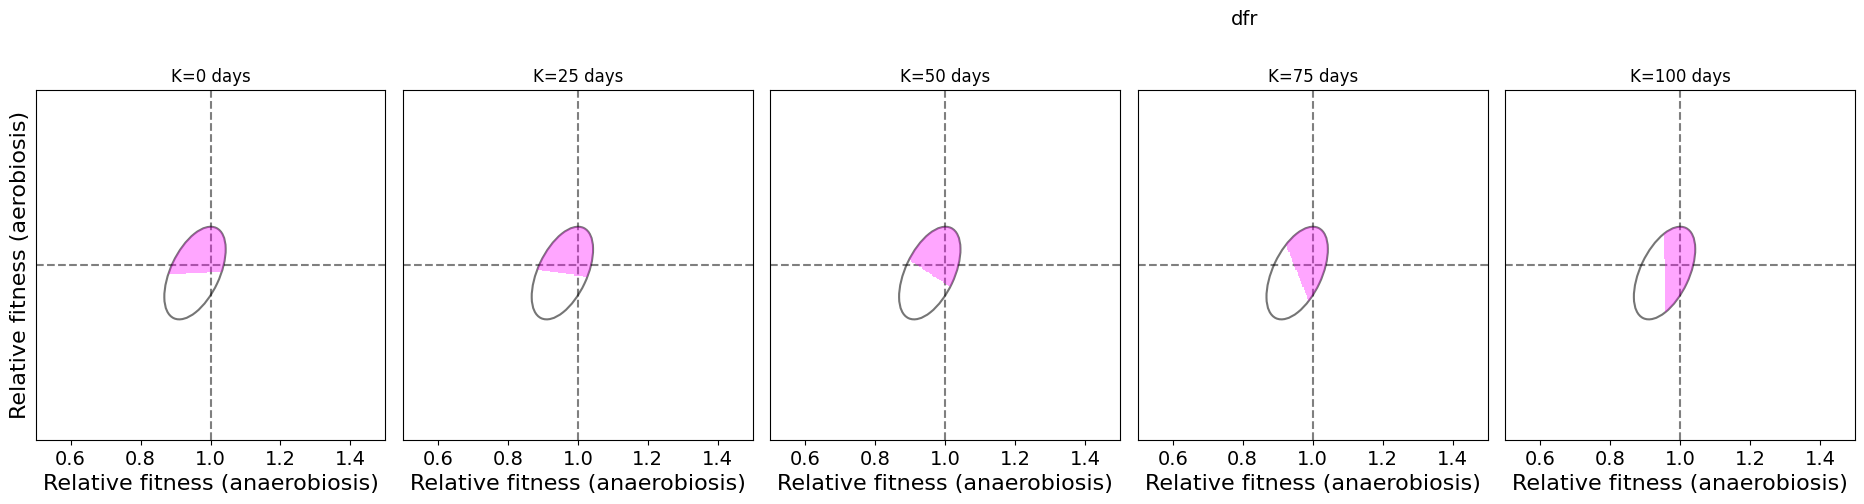


Family: bla
  K=0: 356 surviving ARCs
  K=25: 354 surviving ARCs
  K=50: 355 surviving ARCs
  K=75: 354 surviving ARCs
  K=100: 402 surviving ARCs
Exported: /content/ARCfitness/figures/surviving_ellipse_panels_bla.pdf


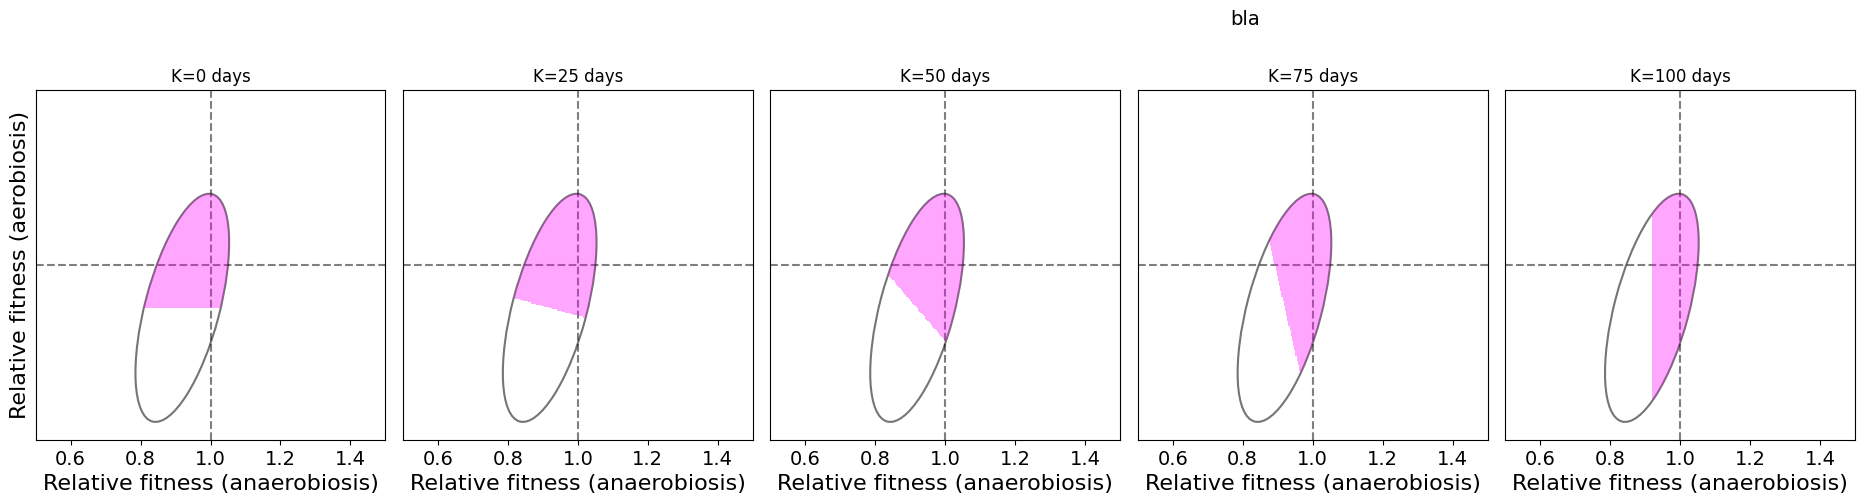


Family: aa
  K=0: 802 surviving ARCs
  K=25: 841 surviving ARCs
  K=50: 875 surviving ARCs
  K=75: 870 surviving ARCs
  K=100: 844 surviving ARCs
Exported: /content/ARCfitness/figures/surviving_ellipse_panels_aa.pdf


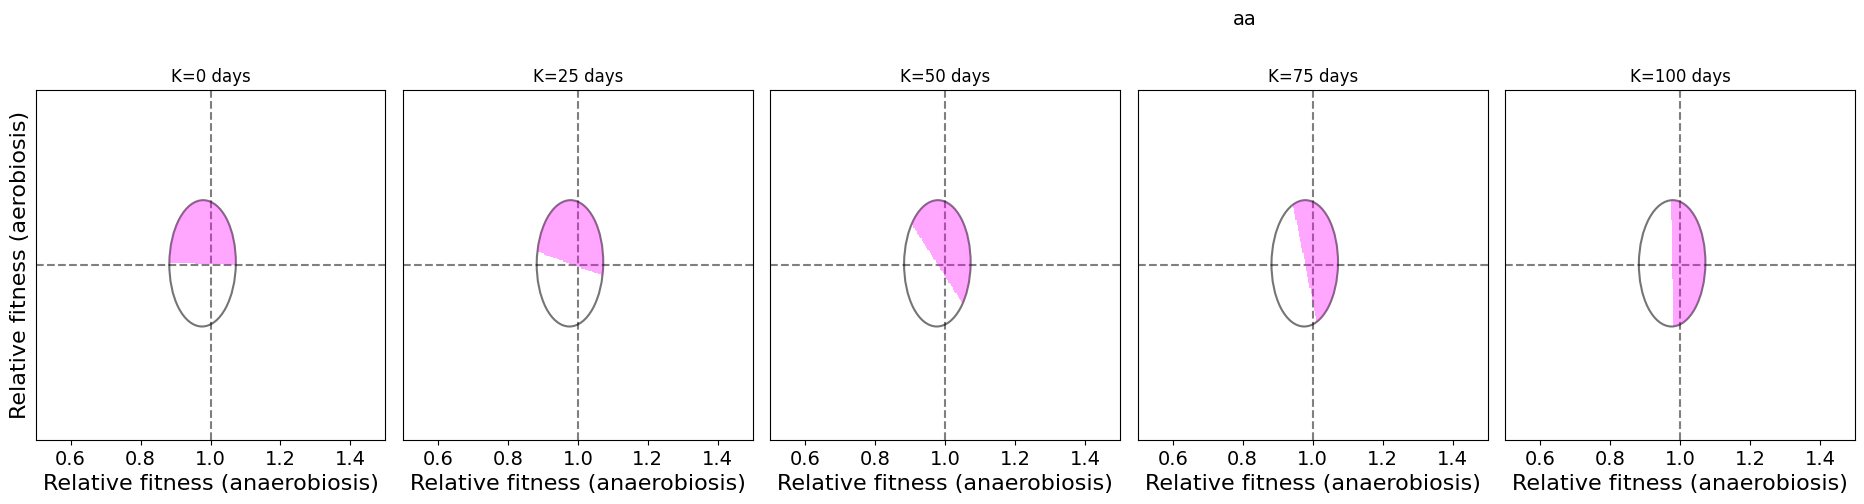


Family: mix
  K=0: 653 surviving ARCs
  K=25: 681 surviving ARCs
  K=50: 718 surviving ARCs
  K=75: 759 surviving ARCs
  K=100: 750 surviving ARCs
Exported: /content/ARCfitness/figures/surviving_ellipse_panels_mix.pdf


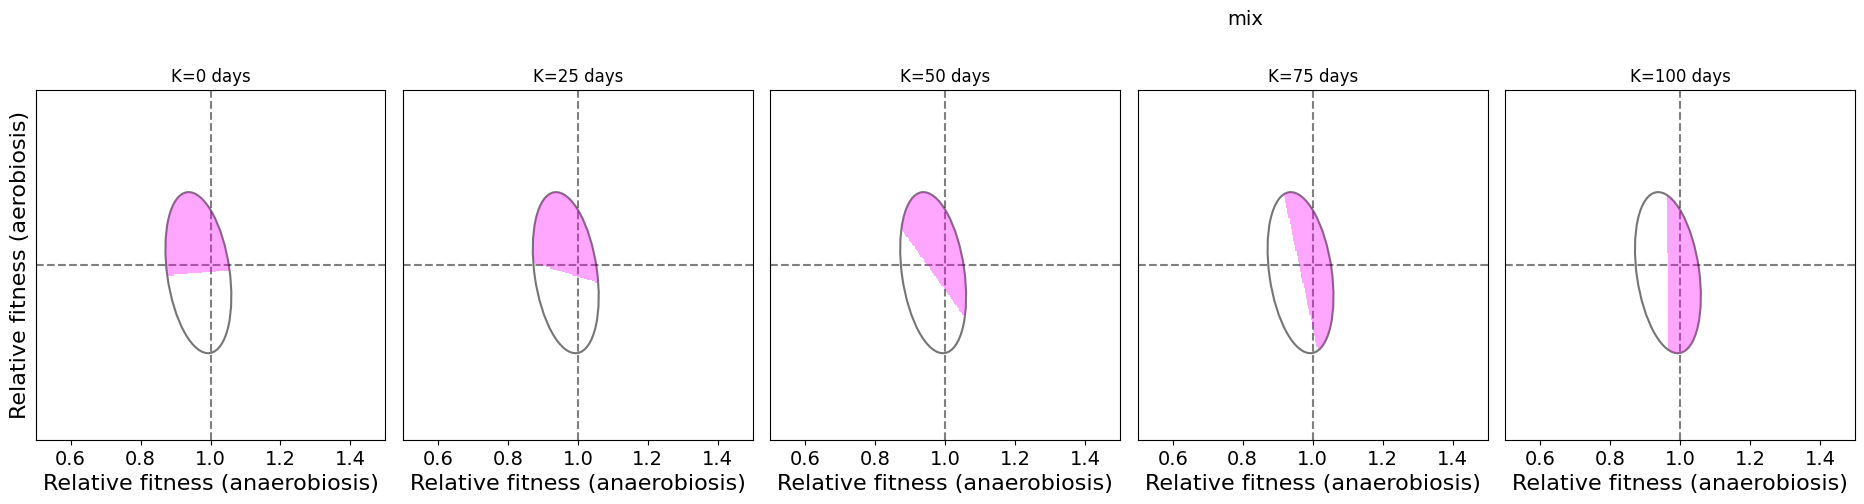


Family: all
  K=0: 740 surviving ARCs
  K=25: 767 surviving ARCs
  K=50: 790 surviving ARCs
  K=75: 811 surviving ARCs
  K=100: 830 surviving ARCs
Exported: /content/ARCfitness/figures/surviving_ellipse_panels_all.pdf


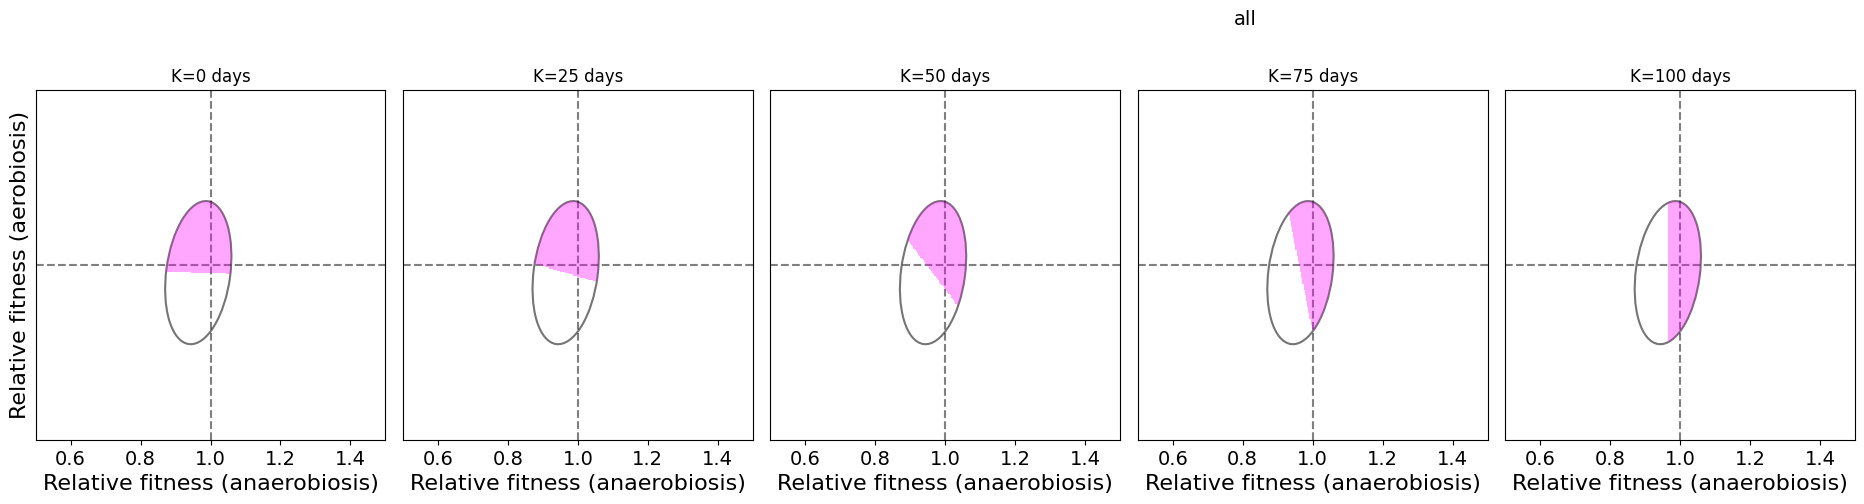

In [36]:
from matplotlib.colors import ListedColormap


# ---------------------------------------------
# K values to plot
# ---------------------------------------------
K_to_plot = [0, 25, 50, 75, 100]

for family in families:
    print(f"\nFamily: {family}")

    # ---------------------------------------------
    # Load experimental + synthetic fitness library
    # ---------------------------------------------
    # Load fitness library for this family
    fitness_csv = REPO_ROOT / "data" / f"fitness_{family}.csv"

    df_family = (
        pd.read_csv(fitness_csv)
          .dropna(how="all")
          .dropna(axis=1, how="all")
    )

    if "family" in df_family.columns and family != "all":
        df_env = df_family[df_family["family"] == family].reset_index(drop=True)
    else:
        df_env = df_family.reset_index(drop=True)
    # ---------------------------------------------
    # Build pivot ONCE per family
    # ---------------------------------------------
    piv = (
        df_env
        .pivot_table(
            index="label",
            columns="Environment",
            values="achieved_w",
            aggfunc="mean"
        )
        .dropna()
    )

    piv = piv[['G', 'E']]  # enforce order

    # ---------------------------------------------
    # Compute FAMILY-LEVEL rotated ellipse
    # ---------------------------------------------
    x = piv['G'].to_numpy(float)
    y = piv['E'].to_numpy(float)

    mx, my = np.mean(x), np.mean(y)

    C = np.cov(np.column_stack([x, y]).T)
    vals, vecs = np.linalg.eigh(C)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    ang_rad = np.arctan2(vecs[1, 0], vecs[0, 0])
    k = 2  # 2-sigma

    a = k * np.sqrt(vals[0])   # semi-major axis
    b = k * np.sqrt(vals[1])   # semi-minor axis


    # ---------------------------------------------
    # Prepare figure
    # ---------------------------------------------
    nK = len(K_to_plot)
    fig, axes = plt.subplots(
        1, nK,
        figsize=(5 * nK, 5),
        sharey=True
    )
    if nK == 1:
        axes = [axes]

    # ---------------------------------------------
    # Loop over K values
    # ---------------------------------------------
    for ax, K in zip(axes, K_to_plot):

        sub_pairs = df_pairs[
            (df_pairs['family'] == family) &
            (df_pairs['K_numeric'] == K)
        ][['label', 'persist_end']].dropna()

        if sub_pairs.empty:
            ax.set_title(f"K={K}")
            ax.axis('off')
            continue

        # surviving labels at this K
        surviving_labels = (
            sub_pairs
            .loc[sub_pairs['persist_end'] == 1, 'label']
            .astype(str)
            .unique()
            .tolist()
        )

        print(f"  K={K}: {len(surviving_labels)} surviving ARCs")

        # -----------------------------------------
        # Highlight mask aligned to piv.index
        # -----------------------------------------
        labels_idx = piv.index.astype(str)
        mask_highlight = labels_idx.isin(surviving_labels)

        # -----------------------------------------
        # Draw shaded ellipse sectors
        # -----------------------------------------
        # 1) background ellipse
        draw_background_ellipse(
            ax,
            mx, my,
            a, b,
            ang_rad,
            edgecolor="#666666",
            lw=1.5,
            alpha=0.9,
            zorder=2
        )

        # 2) shaded region inside ellipse
        add_linear_gate_overlay_clipped_to_ellipse(
            ax=ax,
            piv=piv,
            mask_highlight=mask_highlight,
            mx=mx, my=my,
            a=a, b=b,
            ang_rad=ang_rad,
            color="magenta",
            fill_alpha=0.35,
            draw_line=False   # or True if you want the separator
        )

        ax.set_xlim(0.5, 1.5)
        ax.set_ylim(0.5, 1.5)
        ax.set_aspect('equal')
        ax.axhline(1, color='black', linestyle='--', alpha=0.5)
        ax.axvline(1, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f"K={K} days")
        ax.set_xlabel("Relative fitness (anaerobiosis)")

    axes[0].set_ylabel("Relative fitness (aerobiosis)")
    fig.suptitle(f"{family}", fontsize=14)

    for ax in axes[1:]:
        ax.set_yticks([])
        ax.set_ylabel("")

    fig.suptitle(f"{family}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 0.15*nK, 0.95])

    plt.subplots_adjust(wspace=0.05)

    if pathFIGURES:
        out = f"{pathFIGURES}/surviving_ellipse_panels_{family}.pdf"
        fig.savefig(out)
        print(f"Exported: {out}")


    plt.show()


In [33]:
from scipy.stats import pearsonr

for family in families:
    # Load fitness library for this family
    fitness_csv = REPO_ROOT / "data" / f"fitness_{family}.csv"

    df_family = (
        pd.read_csv(fitness_csv)
          .dropna(how="all")
          .dropna(axis=1, how="all")
    )

    if "family" in df_family.columns and family != "all":
        df_env = df_family[df_family["family"] == family].reset_index(drop=True)
    else:
        df_env = df_family.reset_index(drop=True)

    if df_env.empty:
        print(f"No data found for family {family}")
        continue

    # Map shorthand codes to full labels
    env_map = {'E': 'aerobic', 'G': 'anaerobic'}
    df_env['Environment'] = df_env['Environment'].map(env_map)

    # Split by environment
    aero = df_env[df_env['Environment'] == 'aerobic']['achieved_w']
    anaero = df_env[df_env['Environment'] == 'anaerobic']['achieved_w']

    if aero.empty or anaero.empty:
        print("Missing aerobic or anaerobic data")
        continue

    merged = pd.merge(
        df_env[df_env['Environment'] == 'aerobic'][['label', 'achieved_w']],
        df_env[df_env['Environment'] == 'anaerobic'][['label', 'achieved_w']],
        on='label',
        suffixes=('_aero', '_anaero')
    )

    waero = merged['achieved_w_aero']
    wanaero = merged['achieved_w_anaero']

    # Pearson correlation and p-value
    r, p = pearsonr(waero, wanaero)
    print("\nDistribution summary (%s): "%family)
    print(f"    Mean aerobic fitness: {waero.mean():.3f}")
    print(f"    Mean anaerobic fitness: {wanaero.mean():.3f}")
    print(f"    Std aerobic fitness: {waero.std(ddof=1):.3f}")
    print(f"    Std anaerobic fitness: {wanaero.std(ddof=1):.3f}")
    print(f"    Covariance: {np.cov(waero, wanaero)[0,1]:.3f}")
    print(f"    Pearson r: {r:.3f}")
    print(f"    p-value: {p:.2e}")



Distribution summary (dfr): 
    Mean aerobic fitness: 0.976
    Mean anaerobic fitness: 0.956
    Std aerobic fitness: 0.066
    Std anaerobic fitness: 0.044
    Covariance: 0.001
    Pearson r: 0.512
    p-value: 3.06e-69

Distribution summary (bla): 
    Mean aerobic fitness: 0.877
    Mean anaerobic fitness: 0.919
    Std aerobic fitness: 0.163
    Std anaerobic fitness: 0.067
    Covariance: 0.006
    Pearson r: 0.571
    p-value: 1.34e-88

Distribution summary (aa): 
    Mean aerobic fitness: 1.004
    Mean anaerobic fitness: 0.977
    Std aerobic fitness: 0.090
    Std anaerobic fitness: 0.048
    Covariance: 0.000
    Pearson r: 0.017
    p-value: 5.89e-01

Distribution summary (mix): 
    Mean aerobic fitness: 0.977
    Mean anaerobic fitness: 0.965
    Std aerobic fitness: 0.115
    Std anaerobic fitness: 0.047
    Covariance: -0.002
    Pearson r: -0.296
    p-value: 4.13e-22

Distribution summary (all): 
    Mean aerobic fitness: 0.978
    Mean anaerobic fitness: 0.965
   